In [ ]:
pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.4 MB/s eta 0:00:00


In [ ]:
pip install pandas numpy matplotlib requests scikit-learn vaderSentiment


Class distribution in 'signal' before adjustment:
 signal
0    3871
Name: count, dtype: int64
Only one class detected, adding simulated 'buy' signals for training.
Class distribution in 'signal' after adjustment:
 signal
0    3871
1       5
Name: count, dtype: int64

Training data preview:
    sentiment_score   price  volume        rsi
13              0.0  170.21   309.0  33.043478
14              0.0  170.21   202.0  33.043478
15              0.0  170.20   423.0  44.186047
16              0.0  170.15   305.0  35.365854
17              0.0  170.10  2698.0  34.939759 13    0
14    0
15    0
16    0
17    0
Name: signal, dtype: int64
Model Accuracy: 0.9987113402061856
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       775
           1       0.00      0.00      0.00         1

    accuracy                           1.00       776
   macro avg       0.50      0.50      0.50       776
weighted avg       1.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


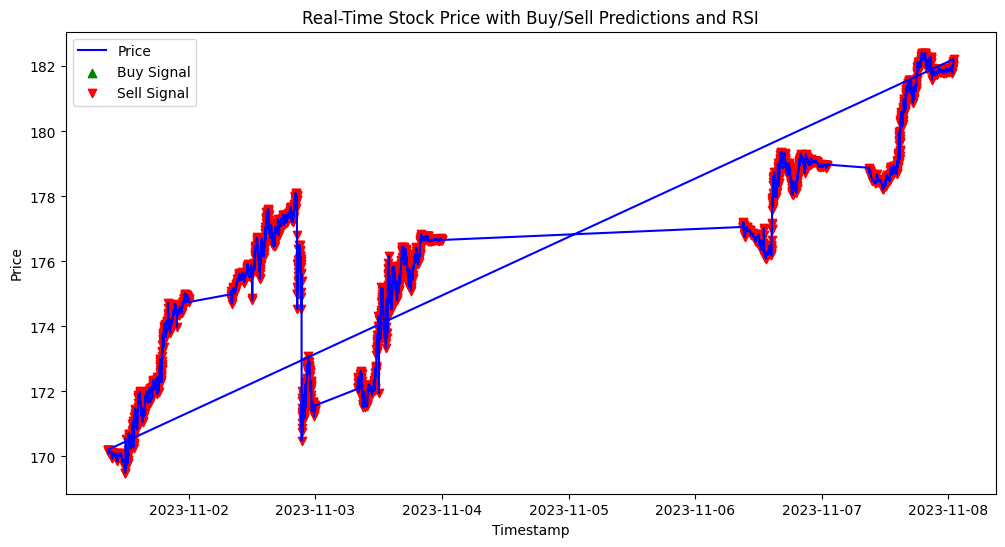

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

API_KEY = 'uc4qBrNqdgTrUYp1p75ze9HMu7_2802Z'

analyzer = SentimentIntensityAnalyzer()

# Fetch real-time data
def fetch_real_time_data(ticker="AAPL"):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/minute/2023-11-01/2023-11-07?apiKey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    return data.get('results', [])

# Calculate RSI
def calculate_rsi(df, period=14):
    delta = df['price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    df['rsi'] = rsi
    return df

# Process data
def process_data(data):
    if not data:
        raise ValueError("No data fetched from Polygon.io API.")

    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['t'], unit='ms')
    df['price'] = df['c']
    df['volume'] = df['v']

    df = calculate_rsi(df)  # Add RSI calculation
    df['sentiment_score'] = df['price'].pct_change().apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
    df['signal'] = df['sentiment_score'].apply(lambda x: 1 if x > 0.05 else 0)

    df.dropna(inplace=True)

    print("Class distribution in 'signal' before adjustment:\n", df['signal'].value_counts())

    if len(df['signal'].value_counts()) < 2:
        print("Only one class detected, adding simulated 'buy' signals for training.")
        simulated_buy = df.iloc[:5].copy()
        simulated_buy['signal'] = 1
        df = pd.concat([df, simulated_buy])

    print("Class distribution in 'signal' after adjustment:\n", df['signal'].value_counts())

    return df

# Machine learning model training
def train_model(df):
    X = df[['sentiment_score', 'price', 'volume', 'rsi']]  # Include RSI as a feature
    y = df['signal']

    if X.isnull().values.any() or not np.isfinite(X).all().all():
        print("Feature matrix X contains NaN or infinite values:")
        print(X)
        raise ValueError("Feature matrix X contains NaN or infinite values")
    if y.isnull().values.any():
        print("Target vector y contains NaN values:")
        print(y)
        raise ValueError("Target vector y contains NaN values")

    print("\nTraining data preview:")
    print(X.head(), y.head())

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("Model Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return model

# Predict signal
def predict_signal(model, df):
    predictions = model.predict(df[['sentiment_score', 'price', 'volume', 'rsi']])
    df['predicted_signal'] = predictions
    return df

# Main execution
data = fetch_real_time_data(ticker="AAPL")
processed_data = process_data(data)
model = train_model(processed_data)
predicted_data = predict_signal(model, processed_data)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(processed_data['timestamp'], processed_data['price'], label='Price', color='blue')
plt.scatter(predicted_data[predicted_data['predicted_signal'] == 1]['timestamp'],
            predicted_data[predicted_data['predicted_signal'] == 1]['price'],
            color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(predicted_data[predicted_data['predicted_signal'] == 0]['timestamp'],
            predicted_data[predicted_data['predicted_signal'] == 0]['price'],
            color='red', label='Sell Signal', marker='v', alpha=1)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Real-Time Stock Price with Buy/Sell Predictions and RSI')
plt.legend()
plt.show()


In [ ]:
# !pip install yfinance -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go

In [ ]:
msft = yf.Ticker("MSFT")

In [ ]:
hist = msft.history(period="max")

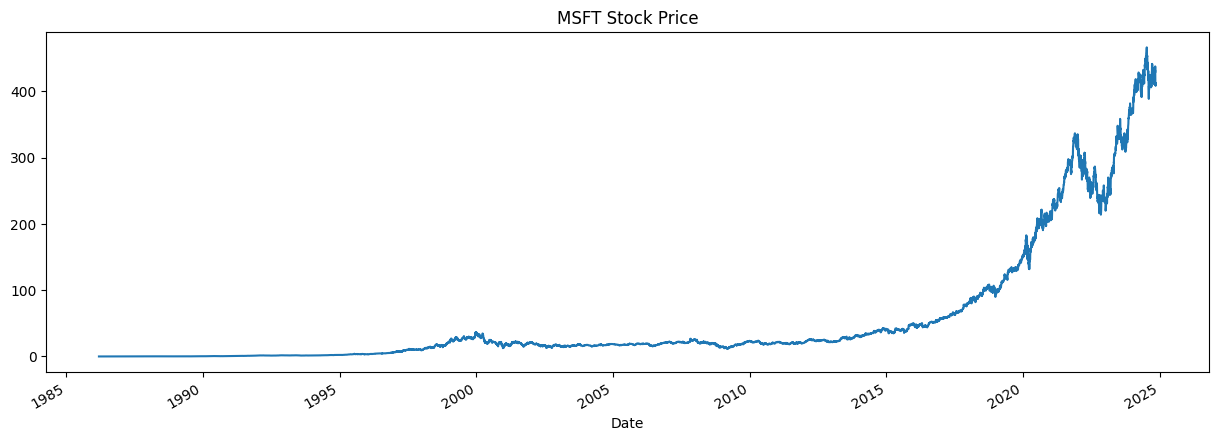

In [ ]:
hist["Open"].plot(figsize=(15, 5), title="MSFT Stock Price")
plt.show()

In [ ]:
stonks = [
    "^GSPC",
    "ETSY",
    "PINS",
    "SQ",
    "SHOP",
    "O",
    "MELI",
    "ISRG",
    "DIS",
    "BRK-B",
    "AMZN",
    "ZM",
    "PFE",
    "CLX",
    "DPZ",
    "RTX",
]

In [ ]:
hists = {}
for s in stonks:
    tkr = yf.Ticker(s)
    history = tkr.history(period="1d")
    hists[s] = history

In [ ]:
for stock in stonks:
    temp_df = hists[stock].copy()

    fig = go.Figure(
        data=[
            go.Candlestick(
                x=temp_df.index,
                open=temp_df["Open"],
                high=temp_df["High"],
                low=temp_df["Low"],
                close=temp_df["Close"],
            )
        ]
    )

    fig.update_layout(
        margin=dict(l=20, r=20, t=60, b=20),
        height=300,
        paper_bgcolor="LightSteelBlue",
        title=stock,
    )

    fig.show()

In [ ]:
hists["CLX"].index.min()

Timestamp('2024-11-06 00:00:00-0500', tz='America/New_York')

In [ ]:
stock = "CLX"

In [ ]:
!pip install snscrape

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install pyarrow



In [ ]:
!pip install fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.2 MB/s eta 0:00:00


In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import time
from tqdm.notebook import tqdm
from snscrape.base import ScraperException
from requests.exceptions import RequestException

# Define the stock symbol dynamically, for example:
stock = "AAPL"

# Create a list to store tweet data
tweets_list = []

# Retry logic parameters
max_retries = 5
retry_delay = 5  # seconds between retries

# Function to fetch tweets with retry logic
def fetch_tweets(query, max_retries, retry_delay):
    retries = 0
    while retries < max_retries:
        try:
            for i, tweet in tqdm(
                enumerate(
                    sntwitter.TwitterSearchScraper(query).get_items()
                ),
                total=12_000,
            ):
                if i >= 12_000:  # Adjusted to break after 12,000 tweets
                    break
                tweets_list.append(
                    [tweet.date, tweet.id, tweet.content, tweet.user.username]
                )
            return True  # Successfully fetched tweets
        except ScraperException as e:
            retries += 1
            print(f"Error occurred, retrying ({retries}/{max_retries})...")
            time.sleep(retry_delay)
        except RequestException as e:
            retries += 1
            print(f"Network error occurred, retrying ({retries}/{max_retries})...")
            time.sleep(retry_delay)
    return False  # Max retries reached without success

# Search query for a specific stock (AAPL) between given dates
query = f"${stock} since:2019-11-04 until:2022-11-02"

# Attempt to fetch tweets
success = fetch_tweets(query, max_retries, retry_delay)

if success:
    # Create a DataFrame from the tweets list
    tweet_df = pd.DataFrame(
        tweets_list, columns=["Datetime", "Tweet Id", "Text", "Username"]
    )

    # Save the DataFrame to a Parquet file
    tweet_df.to_parquet("clx_tweets.parquet", engine='pyarrow')

    # Display first few rows of the DataFrame
    print(tweet_df.head())

    # Now you can continue with your sentiment analysis
    sent_results = {}
    count = 0

    # Check if tweet_df exists and proceed
    if 'tweet_df' in locals():
        for i, d in tqdm(tweet_df.iterrows(), total=len(tweet_df)):
            # Placeholder for sentiment task
            sent = sentiment_task(d["Text"])  # Replace with your sentiment analysis function
            sent_results[d["Tweet Id"]] = sent
    else:
        print("tweet_df is not defined. Ensure that tweets were successfully fetched.")
else:
    print("Failed to fetch tweets after maximum retries.")


  0%|          | 0/12000 [00:00<?, ?it/s]

ERROR:snscrape.base:Error retrieving https://twitter.com/search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click: SSLError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)')))"))
CRITICAL:snscrape.base:4 requests to https://twitter.com/search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click failed, giving up.
CRITICAL:snscrape.base:Errors: SSLError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click (Caused by SSLError(SSLCertV

Error occurred, retrying (1/5)...


  0%|          | 0/12000 [00:00<?, ?it/s]

ERROR:snscrape.base:Error retrieving https://twitter.com/search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click: SSLError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)')))"))
CRITICAL:snscrape.base:4 requests to https://twitter.com/search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click failed, giving up.
CRITICAL:snscrape.base:Errors: SSLError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click (Caused by SSLError(SSLCertV

Error occurred, retrying (2/5)...


  0%|          | 0/12000 [00:00<?, ?it/s]

ERROR:snscrape.base:Error retrieving https://twitter.com/search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click: SSLError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)')))"))
CRITICAL:snscrape.base:4 requests to https://twitter.com/search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click failed, giving up.
CRITICAL:snscrape.base:Errors: SSLError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click (Caused by SSLError(SSLCertV

Error occurred, retrying (3/5)...


  0%|          | 0/12000 [00:00<?, ?it/s]

ERROR:snscrape.base:Error retrieving https://twitter.com/search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click: SSLError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)')))"))
CRITICAL:snscrape.base:4 requests to https://twitter.com/search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click failed, giving up.
CRITICAL:snscrape.base:Errors: SSLError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click (Caused by SSLError(SSLCertV

Error occurred, retrying (4/5)...


  0%|          | 0/12000 [00:00<?, ?it/s]

ERROR:snscrape.base:Error retrieving https://twitter.com/search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click: SSLError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)')))"))
CRITICAL:snscrape.base:4 requests to https://twitter.com/search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click failed, giving up.
CRITICAL:snscrape.base:Errors: SSLError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=%24AAPL+since%3A2019-11-04+until%3A2022-11-02&src=spelling_expansion_revert_click (Caused by SSLError(SSLCertV

Error occurred, retrying (5/5)...
Failed to fetch tweets after maximum retries.


In [ ]:
from transformers import pipeline

model = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

sentiment_task = pipeline("sentiment-analysis", model=model)
sentiment_task("Apple stock sentiment")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'label': 'neutral', 'score': 0.7322036623954773}]

In [ ]:
print(len(tweets_list))

0


In [ ]:
print(f"Number of tweets fetched: {len(tweets_list)}")

Number of tweets fetched: 0


In [ ]:
def fetch_tweets(query, max_retries, retry_delay):
    retries = 0
    while retries < max_retries:
        try:
            for i, tweet in tqdm(
                enumerate(sntwitter.TwitterSearchScraper(query).get_items())
            ):
                tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
            return True
        except ScraperException as e:
            retries += 1
            print(f"Error occurred while scraping: {e}")
            time.sleep(retry_delay * 2)  # Increasing delay between retries
        except RequestException as e:
            retries += 1
            print(f"Network error occurred: {e}")
            time.sleep(retry_delay * 2)  # Increasing delay between retries
    return False


In [ ]:
query = "Bitcoin since:2021-01-01 until:2021-02-01"


In [ ]:
query = "hello since:2021-01-01 until:2021-02-01"


In [ ]:
!pip install tweepy


In [ ]:
import tweepy
import pandas as pd

# Set up Tweepy client with your API keys
consumer_key = 'Hcg6YWI6SYdNjQANtwQ11iTfL'
consumer_secret = 'Aicsqe4a3z6RkBeuCoFIKmHFBmTPfkBQopeaZEjU1AN6A5sEAG'
access_token = '1470764527952314369-C68MdE2cMtXcZEmhq1mjUjmHQBlwUX'
access_token_secret = '1AQmvBXEcdyWuRggxqnVo5nlsMk2DteqEzrN4M60a1WFS'

auth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)
client = tweepy.Client(AAAAAAAAAAAAAAAAAAAAADFcwwEAAAAApW5PWR4V5TX409ogWloGdjBDnlc%3D40ksqOweeX2oQrO9lQfqGhnGCZbVIcJHnUn0IFkBB7S5OuIOw7) # Creating a client instance with bearer token

# Define the query
query = "$AAPL since:2021-01-01 until:2021-02-01"
tweets_list = []

# Fetch tweets using search_recent_tweets from v2 API
# Applying pagination to retrieve more tweets if needed
for response in tweepy.Paginator(client.search_recent_tweets, query=query,
                                 tweet_fields=['created_at', 'text'],
                                 user_fields=['username'],
                                 max_results=100).flatten(limit=99):
    tweets_list.append([response.created_at, response.id, response.text, response.author.username])


# Create DataFrame
tweet_df = pd.DataFrame(tweets_list, columns=["Datetime", "Tweet Id", "Text", "Username"])

# Check first few rows
print(tweet_df.head())

SyntaxError: invalid decimal literal (<ipython-input-68-171e0c7ebdb3>, line 11)

In [ ]:
import nltk
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import classification_report

# Download VADER lexicon
nltk.download('vader_lexicon')

# Finviz URL and ticker list
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AAPL']

news_tables = {}

# Scrape news headlines
for ticker in tickers:
    try:
        url = finviz_url + ticker
        req = Request(url=url, headers={'user-agent': 'Mozilla/5.0'})
        response = urlopen(req)
        html = BeautifulSoup(response, 'html.parser')
        news_table = html.find(id='news-table')

        if news_table:
            news_tables[ticker] = news_table
        else:
            print(f"Warning: No news table found for {ticker}")

    except Exception as e:
        print(f"Error scraping {ticker}: {e}")

# Parse news headlines and dates
parsed_data = []
for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        try:
            title = row.a.text if row.a else "No title available"
            date_data = row.td.text.split(' ')

            if len(date_data) == 1:
                time = date_data[0]
                date = datetime.datetime.today().strftime('%Y-%m-%d')
            else:
                date = date_data[0]
                time = date_data[1]

            parsed_data.append([ticker, date, time, title])

        except Exception as e:
            print(f"Error parsing row: {e}")

# Convert parsed data to a DataFrame
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

# Prompt user to display the scraped data
show_data = input("Do you want to display the scraped data before analyzing? (yes/no): ").strip().lower()
if show_data == 'yes':
    print("\nScraped Data:\n")
    print(df.head(20))  # Display the first 20 rows for preview

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

def analyze_sentiment(title):
    sentiment = vader.polarity_scores(title)
    return pd.Series({
        'compound': sentiment['compound'],
        'positive': sentiment['pos'],
        'neutral': sentiment['neu'],
        'negative': sentiment['neg']
    })

# Apply sentiment analysis
df[['compound', 'positive', 'neutral', 'negative']] = df['title'].apply(analyze_sentiment)

# Assuming you have ground truth labels for each news headline
# (replace with your actual ground truth labels)
df['true_label'] = [1, 0, 1, 0, 1, ...]  # Example ground truth labels

# Assuming a threshold to classify sentiment (e.g., 0.05)
threshold = 0.05
df['predicted_label'] = df['compound'].apply(lambda x: 1 if x > threshold else 0)

# Calculate classification report
report = classification_report(df['true_label'], df['predicted_label'])
print(report)

# Drop unnecessary columns
df.drop(columns=['time'], inplace=True)

# Group by date and ticker and calculate mean sentiment scores
numeric_columns = ['compound', 'positive', 'neutral', 'negative']
df_grouped = df.groupby(['date', 'ticker'])[numeric_columns].mean()

# Plotting the average sentiment over time
plt.figure(figsize=(12, 6))
for ticker in tickers:
    ticker_data = df_grouped.xs(ticker, level='ticker')
    plt.plot(ticker_data.index, ticker_data['compound'], marker='o', label=ticker)

plt.title('Average Sentiment Over Time by Ticker')
plt.ylabel('Compound Sentiment Score')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(title='Ticker')
plt.tight_layout()
plt.show()

# Plotting the average sentiment by ticker
plt.figure(figsize=(10, 6))
mean_df = df.groupby(['ticker'])[numeric_columns].mean()
mean_df[['compound']].plot(kind='bar', color=['#1f77b4'])
plt.title('Average Sentiment by Ticker')
plt.ylabel('Average Compound Sentiment Score')
plt.xlabel('Ticker')
plt.tight_layout()
plt.show()

# Save to CSV
df.to_csv('scraped_news_sentiment.csv', index=False)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Do you want to display the scraped data before analyzing? (yes/no): yes

Scraped Data:

   ticker        date     time  \
0    AAPL        \r\n            
1    AAPL        \r\n            
2    AAPL        \r\n            
3    AAPL        \r\n            
4    AAPL        \r\n            
5    AAPL  2024-11-08  01:05PM   
6    AAPL        \r\n            
7    AAPL        \r\n            
8    AAPL        \r\n            
9    AAPL        \r\n            
10   AAPL        \r\n            
11   AAPL        \r\n            
12   AAPL        \r\n            
13   AAPL        \r\n            
14   AAPL        \r\n            
15   AAPL        \r\n            
16   AAPL  2024-11-08  04:15AM   
17   AAPL        \r\n            
18   AAPL        \r\n            
19   AAPL        \r\n            

                                                title  
0   Match Group (MTCH) Q3 2024 Earnings Call Trans...  
1   Nvidia surpasses $3.6 trillion market value af...  
2   ANZ Profit Drops as Compe

<ipython-input-14-b43f288641d3>:66: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


ValueError: Length of values (6) does not match length of index (103)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Do you want to display the scraped data before analyzing? (yes/no): yes

Scraped Data:

   ticker        date     time  \
0    AAPL        \r\n            
1    AAPL        \r\n            
2    AAPL        \r\n            
3    AAPL        \r\n            
4    AAPL        \r\n            
5    AAPL  2024-11-08  01:05PM   
6    AAPL        \r\n            
7    AAPL        \r\n            
8    AAPL        \r\n            
9    AAPL        \r\n            
10   AAPL        \r\n            
11   AAPL        \r\n            
12   AAPL        \r\n            
13   AAPL        \r\n            
14   AAPL        \r\n            
15   AAPL        \r\n            
16   AAPL  2024-11-08  04:15AM   
17   AAPL        \r\n            
18   AAPL        \r\n            
19   AAPL        \r\n            

                                                title  
0   Match Group (MTCH) Q3 2024 Earnings Call Trans...  
1   Nvidia surpasses $3.6 trillion market value af...  
2   ANZ Profit Drops as Compe

<ipython-input-5-b034d7beb0e1>:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


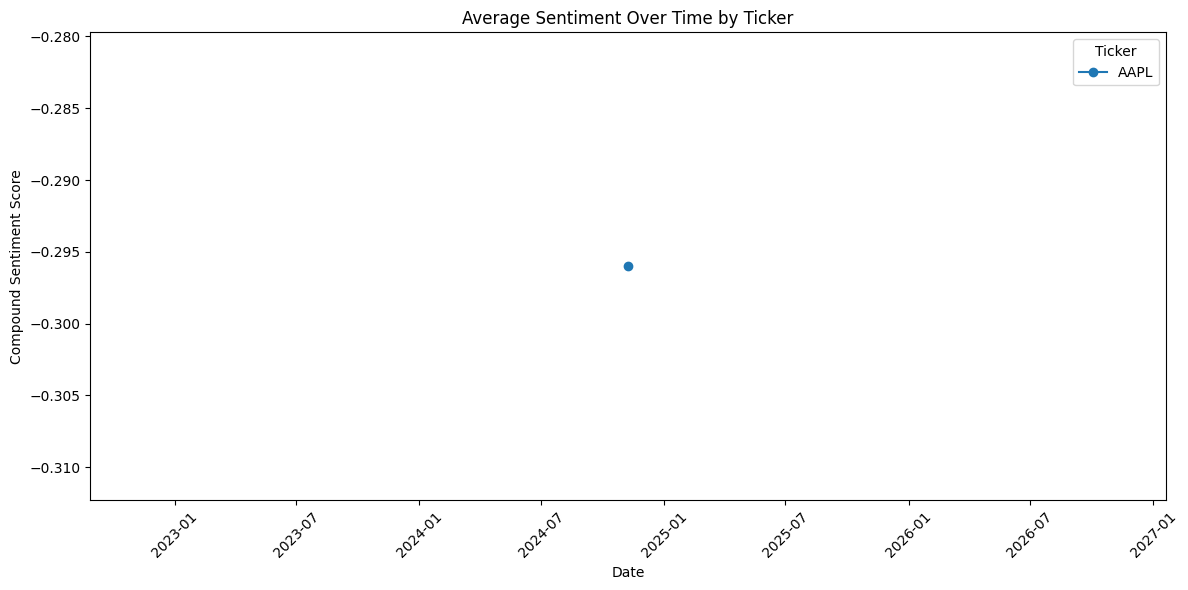

<Figure size 1000x600 with 0 Axes>

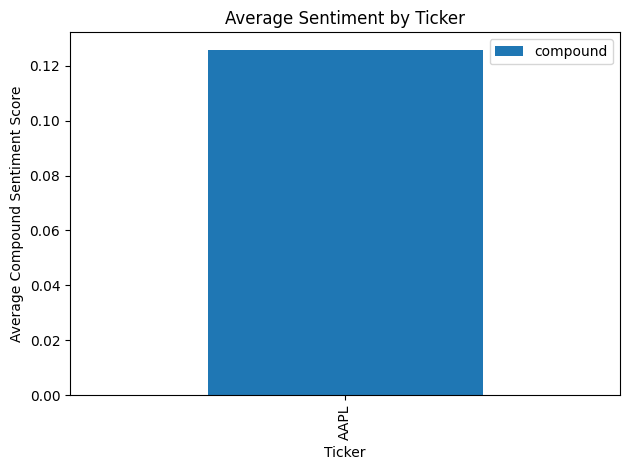

In [ ]:
import nltk
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import datetime

nltk.download('vader_lexicon')

finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AAPL']

news_tables = {}

for ticker in tickers:
    try:
        url = finviz_url + ticker
        req = Request(url=url, headers={'user-agent': 'Mozilla/5.0'})
        response = urlopen(req)
        html = BeautifulSoup(response, 'html.parser')
        news_table = html.find(id='news-table')

        if news_table:
            news_tables[ticker] = news_table
        else:
            print(f"Warning: No news table found for {ticker}")

    except Exception as e:
        print(f"Error scraping {ticker}: {e}")

# Parsing
parsed_data = []
for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        try:
            title = row.a.text if row.a else "No title available"
            date_data = row.td.text.split(' ')

            if len(date_data) == 1:
                time = date_data[0]
                date = datetime.datetime.today().strftime('%Y-%m-%d')
            else:
                date = date_data[0]
                time = date_data[1]

            parsed_data.append([ticker, date, time, title])

        except Exception as e:
            print(f"Error parsing row: {e}")

df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

show_data = input("Do you want to display the scraped data before analyzing? (yes/no): ").strip().lower()
if show_data == 'yes':
    print("\nScraped Data:\n")
    print(df.head(20))

df['date'] = pd.to_datetime(df['date'], errors='coerce')

vader = SentimentIntensityAnalyzer()

def analyze_sentiment(title):
    sentiment = vader.polarity_scores(title)
    return pd.Series({
        'compound': sentiment['compound'],
        'positive': sentiment['pos'],
        'neutral': sentiment['neu'],
        'negative': sentiment['neg']
    })

df[['compound', 'positive', 'neutral', 'negative']] = df['title'].apply(analyze_sentiment)

df.drop(columns=['time'], inplace=True)

numeric_columns = ['compound', 'positive', 'neutral', 'negative']
df_grouped = df.groupby(['date', 'ticker'])[numeric_columns].mean()

plt.figure(figsize=(12, 6))
for ticker in tickers:
    ticker_data = df_grouped.xs(ticker, level='ticker')
    plt.plot(ticker_data.index, ticker_data['compound'], marker='o', label=ticker)

plt.title('Average Sentiment Over Time by Ticker')
plt.ylabel('Compound Sentiment Score')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(title='Ticker')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
mean_df = df.groupby(['ticker'])[numeric_columns].mean()
mean_df[['compound']].plot(kind='bar', color=['#1f77b4'])
plt.title('Average Sentiment by Ticker')
plt.ylabel('Average Compound Sentiment Score')
plt.xlabel('Ticker')
plt.tight_layout()
plt.show()

df.to_csv('scraped_news_sentiment.csv', index=False)


In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Create a VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Input the news article
text = "Apple's latest iPhone 15 Pro Max is a game-changer! The stunning Dynamic Island display, powerful A17 Bionic chip, and groundbreaking camera system have left tech enthusiasts awestruck. However, the exorbitant price tag might deter some potential buyers."

# Analyze the sentiment
sentiment = analyzer.polarity_scores(text)

print(sentiment)

{'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compound': 0.8655}


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Generate random timestamps (from the past 100 days)
timestamps = pd.date_range(end=pd.Timestamp.today(), periods=10000, freq='T')

# Generate random initial price and random fluctuations
initial_price = 100
price_changes = np.random.normal(loc=0, scale=10, size=10000)  # Large price noise

# Create prices with random fluctuations
prices = initial_price + np.cumsum(price_changes)

# Generate random volumes (between 1000 and 10000)
volumes = np.random.randint(1000, 10000, size=10000)

# Create random signals that are not correlated with the price changes
# 50% of the signals will be randomly assigned as 1 or 0 (no meaningful pattern)
signals = np.random.randint(0, 2, size=10000)

# Create DataFrame with random data
data = pd.DataFrame({
    't': timestamps.astype(np.int64) // 10**6,  # Convert timestamps to milliseconds
    'c': prices,
    'v': volumes,
    'signal': signals
})

# Save to CSV (optional, if you want to save to a file)
data.to_csv("data_with_noise.csv", index=False)

# Display the first few rows of the generated data
print(data.head())


               t           c     v  signal
0  1730427699493  104.967142  2897       0
1  1730427759493  103.584499  6751       1
2  1730427819493  110.061384  6150       1
3  1730427879493  125.291682  2697       0
4  1730427939493  122.950149  6885       1


<ipython-input-11-4c5752ffa7c4>:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(end=pd.Timestamp.today(), periods=10000, freq='T')


Class distribution in 'signal' before adjustment:
 signal
0    10000
Name: count, dtype: int64
Only one class detected, adding simulated 'buy' signals for training.
Class distribution in 'signal' after adjustment:
 signal
0    10000
1        5
Name: count, dtype: int64

Training data preview:
   sentiment_score       price  volume
0              0.0  104.967142    2897
1              0.0   98.617357    6751
2              0.0  106.476885    6150
3              0.0  115.230299    2697
4              0.0   97.658466    6885 0    0
1    0
2    0
3    0
4    0
Name: signal, dtype: int64
Model Accuracy: 0.9985007496251874
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1998
           1       0.00      0.00      0.00         3

    accuracy                           1.00      2001
   macro avg       0.50      0.50      0.50      2001
weighted avg       1.00      1.00      1.00      2001



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


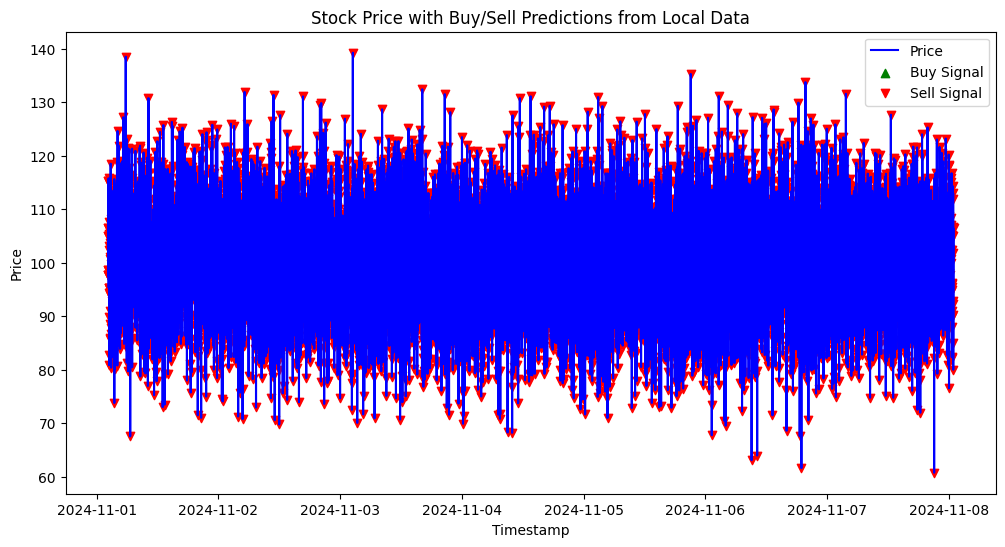

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

analyzer = SentimentIntensityAnalyzer()

# Load data from a CSV file instead of API
def load_data_from_file(file_path="data_with_noise.csv"):
    try:
        df = pd.read_csv(file_path)

        # Check if necessary columns are present
        required_columns = {'t', 'c', 'v'}
        if not required_columns.issubset(df.columns):
            raise ValueError(f"File must contain columns {required_columns}")

        df['timestamp'] = pd.to_datetime(df['t'], unit='ms')
        df['price'] = df['c']
        df['volume'] = df['v']

        return df
    except Exception as e:
        print(f"Error loading data from file: {e}")
        return pd.DataFrame()

# Processing data as before
def process_data(df):
    if df.empty:
        raise ValueError("No data loaded from the file.")

    df['sentiment_score'] = df['price'].pct_change().apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
    df['signal'] = df['sentiment_score'].apply(lambda x: 1 if x > 0.05 else 0)
    df.dropna(inplace=True)

    print("Class distribution in 'signal' before adjustment:\n", df['signal'].value_counts())

    if len(df['signal'].value_counts()) < 2:
        print("Only one class detected, adding simulated 'buy' signals for training.")
        simulated_buy = df.iloc[:5].copy()
        simulated_buy['signal'] = 1
        df = pd.concat([df, simulated_buy])

    print("Class distribution in 'signal' after adjustment:\n", df['signal'].value_counts())
    return df

# Machine learning model training
def train_model(df):
    X = df[['sentiment_score', 'price', 'volume']]
    y = df['signal']

    if X.isnull().values.any() or not np.isfinite(X).all().all():
        print("Feature matrix X contains NaN or infinite values:")
        print(X)
        raise ValueError("Feature matrix X contains NaN or infinite values")
    if y.isnull().values.any():
        print("Target vector y contains NaN values:")
        print(y)
        raise ValueError("Target vector y contains NaN values")

    print("\nTraining data preview:")
    print(X.head(), y.head())

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("Model Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return model

def predict_signal(model, df):
    predictions = model.predict(df[['sentiment_score', 'price', 'volume']])
    df['predicted_signal'] = predictions
    return df

# Replace API call with file loading
data = load_data_from_file(file_path="data.csv")
processed_data = process_data(data)
model = train_model(processed_data)
predicted_data = predict_signal(model, processed_data)

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(processed_data['timestamp'], processed_data['price'], label='Price', color='blue')
plt.scatter(predicted_data[predicted_data['predicted_signal'] == 1]['timestamp'],
            predicted_data[predicted_data['predicted_signal'] == 1]['price'],
            color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(predicted_data[predicted_data['predicted_signal'] == 0]['timestamp'],
            predicted_data[predicted_data['predicted_signal'] == 0]['price'],
            color='red', label='Sell Signal', marker='v', alpha=1)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Stock Price with Buy/Sell Predictions from Local Data')
plt.legend()
plt.show()
